# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
df.shape

(45993, 3)

In [3]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
df_content.shape

(1056, 5)

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

**Answer:**

Figure 1 below shows the "Article reading distribution" by users (the distribution of how many articles a user interacts with in the dataset: each article is counted only once per user). 

Figure 2 shows the distribution of user-article interactions for a single user.

Figure 3 shows the Box plot of the five-number summary of the distribution.

In [5]:
df.email.nunique()

5148

In [6]:
df[df['email'] == '2b6c0f514c2f2b04ad3c4583407dccd0810469ee'].shape

(364, 3)

In [7]:
user_unique_articles = df.groupby(['email'])['article_id'].nunique()
user_unique_articles

email
0000b6387a0366322d7fbfc6434af145adf7fed1    12
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     5
001fc95b90da5c3cb12c501d201a915e4f093290     2
                                            ..
ffc6cfa435937ca0df967b44e9178439d04e3537     1
ffc96f8fbb35aac4cb0029332b0fc78e7766bb5d     2
ffe3d0543c9046d35c2ee3724ea9d774dff98a32    27
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81     7
fffb93a166547448a0ff0232558118d59395fecd     6
Name: article_id, Length: 5148, dtype: int64

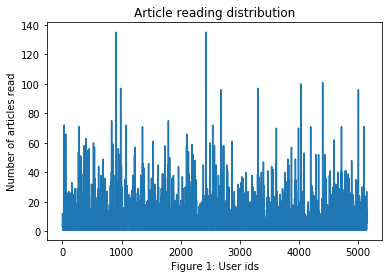

In [8]:
user_unique_articles_array = user_unique_articles.values
plt.plot(user_unique_articles_array)
plt.xlabel('Figure 1: User ids');
plt.ylabel('Number of articles read');
plt.title('Article reading distribution'); #the distribution of how many articles a user interacts with in the dataset

In [9]:
user_unique_articles['fffb93a166547448a0ff0232558118d59395fecd']

6

In [10]:
user_article_interaction = df.groupby(['email', 'article_id']).count()
user_article_interaction.tail(20)

title
email                                    article_id       
ffe3d0543c9046d35c2ee3724ea9d774dff98a32 1165.0          1
                                         1314.0          2
                                         1360.0          2
                                         1386.0          1
                                         1422.0          3
                                         1425.0          1
                                         1427.0          1
fff9fc3ec67bd18ed57a34ed1e67410942c4cd81 116.0           1
                                         232.0           1
                                         268.0           2
                                         525.0           1
                                         684.0           3
                                         962.0           1
                                         1431.0          1
fffb93a166547448a0ff0232558118d59395fecd 329.0           1
                                         981.0           1
                                         1304.0          1
                                         1305.0          8
                                         1430.0          1
                                         1437.0          1

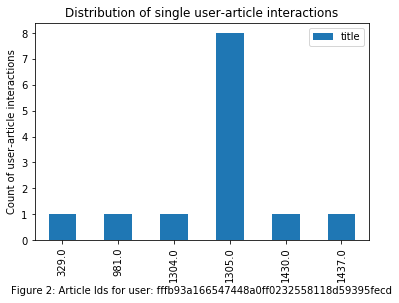

In [11]:
user_article_interaction.loc['fffb93a166547448a0ff0232558118d59395fecd', :].plot(kind='bar')
plt.xlabel('Figure 2: Article Ids for user: fffb93a166547448a0ff0232558118d59395fecd');
plt.ylabel('Count of user-article interactions');
plt.title('Distribution of single user-article interactions');


In [12]:
user_unique_articles.min()

1

In [13]:
user_unique_articles.quantile(0.25)

1.0

In [14]:
user_unique_articles.quantile(0.5)

3.0

In [15]:
user_unique_articles.quantile(0.75)

7.0

In [16]:
user_unique_articles.median()

3.0

In [17]:
user_unique_articles.max()

135

In [18]:
# The maximum number of user-article interactions by any 1 user 
df.groupby(['email']).count()['article_id'].max()

364

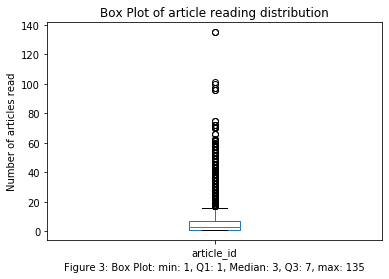

In [19]:
user_unique_articles.plot(kind = 'box')
plt.xlabel('Figure 3: Box Plot: min: 1, Q1: 1, Median: 3, Q3: 7, max: 135');
plt.ylabel('Number of articles read');
plt.title('Box Plot of article reading distribution');

In [20]:
# Fill in the median and maximum number of user_article interactions below

median_val = 3.0 # 50% of individuals interact with __3__ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is _135_____.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [21]:
df_content[df_content.article_id.duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [22]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'])

In [23]:
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [24]:
# The number of unique articles that have at least one interaction
df[~df['email'].isnull()]['article_id'].nunique()

714

In [25]:
# The number of unique articles on the IBM platform
s1 = set(df['article_id']) # The set of unique articles that have at least one interaction
s2 = set(df_content['article_id']) # The set of unique articles on the IBM platform
s = s1.union(s2) # What this represents?
len(s1), len(s2), len(s)

(714, 1051, 1328)

In [26]:
# The number of unique users
df['email'].nunique(dropna=True)

5148

In [27]:
# The number of user-article interactions
df.shape[0]

45993

In [28]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # 45976 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [29]:
not_null_df = df[~df['email'].isnull()][~df['article_id'].isnull()]
# The most viewed article in the dataset was viewed how many times?
max_number = not_null_df.groupby('article_id').count()['email'].max()
max_number

/Users/yuhuang/anaconda3/envs/deeplearning/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


937

In [30]:
# The most viewed article in the dataset as a string with one value following the decimal 
count_df = not_null_df.groupby('article_id').count()
count_df[count_df['title'] == max_number].index[0]

1429.0

In [31]:
most_viewed_article_id = str(1429.0) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [32]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column
def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [33]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [34]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    # This can be done by calling the function get_top_article_ids() below.
    top_n_articles = df.groupby(['article_id']).count()['title'].sort_values(ascending=False).index[0:n]
    top_articles = []
    
    for article_id in top_n_articles:
        title = df[df['article_id'] == article_id]['title'].values[0]
        top_articles.append(title)

    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here. 
    top_articles = df.groupby(['article_id']).count()['title'].sort_values(ascending=False).index[0:n].tolist()
    
    return top_articles # Return the top article ids

In [35]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [36]:
def save_to_pickle_file(data, file_name):
    outfile = open(file_name,'wb')
    pickle.dump(data, outfile)
    outfile.close()
    return

# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
save_to_pickle_file(top_5, "top_5.p")

top_10 = get_top_articles(10)
save_to_pickle_file(top_10, "top_10.p")

top_20 = get_top_articles(20)
save_to_pickle_file(top_20, "top_20.p")

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [37]:
# create the user-article matrix with 1's and 0's
# TO DO: write a function 

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    # Fill in the function here
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item.fillna(0, inplace=True)
    user_item[user_item > 0] = 1
    
    '''
    #
    # The following code works, but it's complicated and slow!
    #
    df_copy = df.copy() # make copy to avoid side-effect on the original df
    
    df_copy['values'] = 1
    df_copy = df_copy[['user_id','title','article_id','values']]
    
    df1 = df_copy.pivot(columns='article_id', values='values')
    df1.fillna(0, inplace=True)
    
    user_ids = [df_copy.loc[idx, 'user_id'] for idx in df1.index]
    df1['user_id'] = user_ids
    
    user_item = pd.DataFrame(columns = df1.columns)

    user_id_set = set(user_ids)
    for user_id in user_id_set:
        # aggregate all of the rows with the same user_id into one row
        row1 = df1[df1['user_id'] == user_id].sum(axis=0)
        # change any value > 1 to 1
        row = []
        for value in row1:
            if value >= 1:
                row.append(1)
            else:
                row.append(0)
        row[-1] = user_id
    
        # add the row aggregated above
        user_item.loc[len(user_item.index)] = row
        
    user_item.set_index('user_id', inplace=True)
    user_item.sort_index(axis=0, inplace=True)
    '''
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [38]:
user_item.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [40]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    sim_dict = dict()
    # find the vector for the user_id passed in.
    v1 = user_item.loc[user_id, :].values
    for i in user_item.index:
        if i != user_id:
            v2 = user_item.loc[i, :].values
            # save each user's dot production in the dict.
            sim_dict[i] = np.dot(v1, v2)

    # sort by similarity
    # NOTE: set reverse=True to sort similarity scores in decending order
    sorted_sim_dict = {k: v for k, v in sorted(sim_dict.items(), key=lambda item: item[1], reverse=True)}
    
    # create list of just the ids
    most_similar_users = list(sorted_sim_dict.keys())
   
    # remove the own user's id
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [41]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [42]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = []
    
    for article_id in article_ids:
        try:
            title = df[df['article_id'] == float(article_id)]['title'].values[0]
            article_names.append(title)
        except:
            print('get_article_names - Exception occured for article_id: ', article_id)
        
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = []
    all_article_ids = user_item.columns
    v1 = user_item.loc[user_id, :].values # numpy array of the row
    
    # find the reading list of the passed in user (user_id)
    for idx, value in enumerate(v1):
        if value == 1:
            article_ids.append(all_article_ids[idx])
    
    article_names = get_article_names(article_ids)
    
    article_ids = [str(aid) for aid in article_ids]
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    # get the article ids and names that are read by the user.
    read_article_ids, read_article_names = get_user_articles(user_id)
    
    recs = []
    
    count = 0
    
    # find similar users
    similar_user_ids = find_similar_users(user_id)
    
    for similar_id in similar_user_ids:
        if count > m:
            break
            
        # for each similar user, find his/her reading list
        article_ids, article_names = get_user_articles(similar_id)
        for aid in article_ids: # go through the reading list
            if (aid not in read_article_ids) and (aid not in recs):
                if count < m:
                    recs.append(aid)
                    count += 1
                else:
                    break
    
    return recs # return your recommendations for this user_id    

In [43]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

In [44]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [45]:
def find_similarity(user_id, similar_user_ids, user_item=user_item):
    '''
    This function is to find the similarity score list based on the similar reading list
    from the neiberhood users.
    '''
    similarity_list = []
    v1 = user_item.loc[user_id, :].values
    for uid in similar_user_ids:
        v2 = user_item.loc[uid, :].values # get numpy array
        # save each user's dot production in the dict.
        similarity_list.append(np.dot(v1, v2))
            
    return similarity_list

def find_interaction(similar_user_ids, df=df):
    '''
    This function is to find the list of interactions based on the list of similar users.
    '''
    interaction_list = []
    for user_id in similar_user_ids:
        num_interaction = df[df['user_id'] == int(user_id)].shape[0]
        interaction_list.append(num_interaction)
            
    return interaction_list

def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    similar_user_ids = find_similar_users(user_id, user_item=user_item)
    similarity_scores = find_similarity(user_id, similar_user_ids)
    user_interactions = find_interaction(similar_user_ids)
    
    neighbors_dict = {'neighbor_id' : similar_user_ids, 
               'similarity'  : similarity_scores, 
               'num_interactions' : user_interactions
              }
    neighbors_df = pd.DataFrame(neighbors_dict)
    
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'], ascending = (False, False))
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here

    read_article_ids, read_article_names = get_user_articles(user_id)
    
    neighbors_df = get_top_sorted_users(user_id)
    
    recs = []
    rec_names = []
    
    count = 0
    
    # find similar users
    similar_user_ids = neighbors_df['neighbor_id'] #find_similar_users(user_id)
    
    for similar_user_id in similar_user_ids:
        if count > m:
            break
         
        #
        # Choose articles with the articles with the most total interactions 
        # before choosing those with fewer total interactions.
        #
        filtered_df = df[df['user_id'] == similar_user_id]
        article_ids   = get_top_article_ids(filtered_df.shape[0], df=filtered_df)
        article_names = get_top_articles(filtered_df.shape[0], df=filtered_df)
        
        for idx, aid in enumerate(article_ids): # go through the reading list
            if (aid not in read_article_ids) and (aid not in recs):
                if count < m:
                    recs.append(aid)
                    rec_names.append(article_names[idx])
                    count += 1
                else:
                    break
    
    return recs, rec_names

In [46]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1276.0, 1172.0, 1278.0, 1329.0, 1360.0, 1170.0, 793.0, 1407.0]

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'deploy your python model as a restful api', 'apache spark lab, part 3: machine learning', 'develop a scala spark model on chicago building violations', 'ingest data from message hub in a streams flow', 'pixieapp for outlier detection', 'apache spark lab, part 1: basic concepts', '10 powerful features on watson data platform, no coding necessary', 'uci: poker hand - testing data set']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [47]:
# Find the user that is most similar to user 1 
get_top_sorted_users(1).iloc[0, 0] 

3933

In [48]:
# Find the 10th most similar user to user 131
get_top_sorted_users(131).iloc[9, 0] 

242

In [49]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [50]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

For a new user who does not exist in the system, we can use the rank-based recommendation function "get_top_article_ids()" to make recommendations becase this function does not depend on the user-article interactions. A better way is to use content-based recommendation method. For example, we can provide a Web user interface to allow a new user to pick key words (e.g., history, data science, etc.) to select articles.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [51]:
get_top_article_ids(10)

[1429.0,
 1330.0,
 1431.0,
 1427.0,
 1364.0,
 1314.0,
 1293.0,
 1170.0,
 1162.0,
 1304.0]

In [52]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(article_id) for article_id in get_top_article_ids(10)] # Your recommendations here

In [53]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [54]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [55]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [56]:
save_to_pickle_file(user_item, 'user_item_matrix.p')

In [57]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [58]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [59]:
user_item_matrix_float = user_item_matrix.astype('float32')
user_item_matrix_float.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix_float.values, full_matrices=False) # use the built in to get the three matrices

In [61]:
u.shape, s.shape, vt.shape

((5149, 714), (714,), (714, 714))

**Provide your response here.**

The dataset in the lession contains missing data and thus the FunkSVD algorithm was used. However, the user-item matrix does not have any missing data, so the numpy svd alrorithm can be utilized here.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

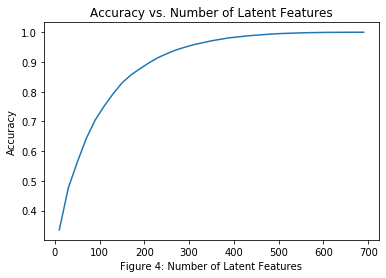

In [62]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
       
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Figure 4: Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [63]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    '''
    #
    # The following code does the same thing, but faster
    #
    
    # get the list of unique article ids from df_train
    article_id_train_list = list(set(df_train['article_id']))
    # extract the columns of the article ids in the training list
    user_item_train = user_item[article_id_train_list]
    
    # the list of the unique user ids from the training data
    user_id_train_list = list(set(df_train['user_id']))
    user_item_train = user_item_train.loc[user_id_train_list, :]
    
    # get all of the test article ids
    test_arts = list(set(df_test['article_id']))
    # extract the columns of the article ids in the test list
    user_item_test = user_item[test_arts]
    
    # get all of the test user ids
    test_idx = list(set(df_test['user_id']))
    user_item_test = user_item_test.loc[test_idx, :] # select the corresponding rows
    '''
    
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)


In [64]:
user_item_train.shape, user_item_test.shape

((4487, 714), (682, 574))

In [65]:
# How many users can we make predictions for in the test set?
predictable_users = set(test_idx).intersection(set(user_item_train.index))
# number of predictable users in the test set
len(predictable_users) # 20
# number of not predictable users = len(test_idx) - 20 
len(test_idx) - 20 # 662

662

In [66]:
# How many articles can we make predictions for in the test set?
pretictable_articles = set(test_arts).intersection(set(user_item_train.columns))
# number of predictable articles in the test set
len(pretictable_articles) # 574
# number of not predictable articles = len(test_arts) - 574 
len(test_arts) - 574 # 0

0

In [67]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many articles can we make predictions for in the test set?': b,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d 
}

# NOTE: The function sol_4_test() in the project_tests package had 
# a spelling error (used "movies" in the place of "articles"), 
# which caused a test failure.
t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [68]:
# fit SVD on the user_item_train matrix
user_item_train_float = user_item_train.astype('float32')
u_train, s_train, vt_train = np.linalg.svd(user_item_train_float.values, full_matrices=False) # fit svd similar to above then use the cells below

In [69]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 714), (714,), (714, 714))

In [70]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
predictable_user_item_test = user_item_test.loc[predictable_users, pretictable_articles]

# Find common user ids shared by training and testing
common_user_idx = user_item_train[user_item_train.index.isin(predictable_users)].index.to_list()

# get vt_test from v_train by finding all of the common columns shared by 
# both training and testing
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]

# get a u_test from u_train
common_user_idx_adjusted = [uid - 1 for uid in common_user_idx]
u_test = u_train[common_user_idx_adjusted, :] # select subset of rows from u_train

s_test = s_train # take all latent features for now

u_test.shape, s_test.shape, vt_test.shape

((20, 714), (714,), (714, 574))

In [71]:
num_latent_feats = np.arange(10,700+10,20)

def get_sum_errors(num_latent_feats, u1, s1, vt1, user_item1):
    '''
    Get a list of total errors of predictions using different numbers of 
    latent features.
    '''
    sum_errs = []

    for k in num_latent_feats:
        
        # restructure with k latent features
        s_new_t, u_new_t, vt_new_t = np.diag(s1[:k]), u1[:, :k], vt1[:k, :]

        # take dot product
        user_item_est = np.around(np.dot(np.dot(u_new_t, s_new_t), vt_new_t))

        # compute error for each prediction to actual value
        diffs = np.subtract(user_item1, user_item_est)

        # total errors and keep track of them
        err = np.sum(np.sum(np.abs(diffs)))
        sum_errs.append(err)
        
    return sum_errs

In [72]:
sum_errs_train = get_sum_errors(num_latent_feats, u_train, s_train, vt_train, user_item_train_float)


In [73]:
predictable_user_item_test_float = predictable_user_item_test.astype('float32')
sum_errs_test = get_sum_errors(num_latent_feats, u_test, s_test, vt_test, 
                               predictable_user_item_test_float)

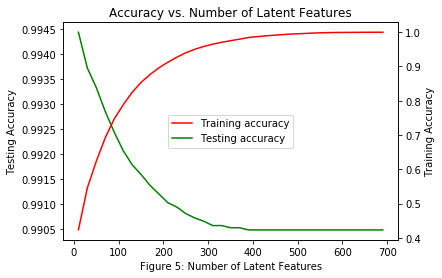

In [74]:
#
# Plot the diagrams of training and testing accuracies over the number of 
# latent features.
#

fig, ax_test = plt.subplots()
ax_train = ax_test.twinx()

ax_train.plot(num_latent_feats, 1 - np.array(sum_errs_train)/df.shape[0], color = 'red', label="Training accuracy");
ax_test.plot(num_latent_feats, 1 - np.array(sum_errs_test)/df.shape[0], color = 'green', label="Testing accuracy");

handler_train, label_train = ax_train.get_legend_handles_labels()
handler_test, label_test = ax_test.get_legend_handles_labels()

ax_train.legend(handler_train + handler_test, label_train + label_test, loc='center')

ax_test.set_xlabel('Figure 5: Number of Latent Features');
ax_train.set_ylabel('Training Accuracy');
ax_test.set_ylabel('Testing Accuracy');
plt.title('Accuracy vs. Number of Latent Features');


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

As the number of latent features increases, the training accuracy increases, but the testing accuracy decreases. According to the diagram above (in Question 5), when the number of latent features is close to 100, the training and the testing accuracy curves cross each other around 99.25%. In other words, 100 latent features may be a good balancing point.

According to this analysis, I would suggest to use 100 latent features to find the u, s, vt metrices as follows for recommendations:

```
k = 100
s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
```

The testing accuracy started to decrease from the beginning and continued to decrease to the end for the following possible reason. The testing user-item metrix contains almost all of zero values (only 218 elements with value of 1). When the number of latent features increases, the restored metrix has more non-zero values, which increases summation of errors. A possible deep reason of decreasing accuracy is because the number of testable users is too small (only 20). In this case, when the number of latent features increases, the SVD model complexity increases, which lead to more overfitting. 

Generally speaking, the accuracy seems not a good metric to use here in this case because a higher accuracy of restoring a decomposed mdtrix is not necessary to indicate that a corresponding recommendation system will make better recommendations. 

A better way of evaluating the model is to use A/B testing. For example, we can use the default number of features of the SVD model as the baseline for the control group, and use a smaller number of latent features to develop a SVD model for the test group. Cookies can be used to distribute users to these two groups randomly. The potential experiment metrics to be tracked can be total number of user-article interactions, average reviewed articles per user, number of users as invariance metric, etc. The time period of the experiment needs to be determined by the number of users interacting with the system per day and the business needs (e.g., experiment metrics, cost, deployment date, etc.).

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

In [75]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

1